In [2]:
import pandas as pd
data = pd.read_csv("Data_with_greeks.csv")
data

,Unnamed: 0,#RIC,Alias Underlying RIC,Domain,Date-Time,Type,Open,High,Low,Last,...,Strike,Expiry,Opt Type,T,IV,time_to_expiry,Delta,Gamma,Theta,Vega
0,0,SPYA192444000.U,NaN,Market Price,2023-10-02 13:00:00+00:00,Intraday 1Hour,10.16,10.47,10.09,10.30,...,440.0,2024-01-19 05:00:00+00:00,call,0.432540,0.112387,108 days 16:00:00,1.00,1.271403e-09,-0.071577,0.000470
1,1,SPYA192444000.U,NaN,Market Price,2023-10-02 14:00:00+00:00,Intraday 1Hour,10.00,10.69,9.92,9.92,...,440.0,2024-01-19 05:00:00+00:00,call,0.432540,0.110519,108 days 15:00:00,1.00,8.705712e-10,-0.071736,0.000316
2,2,SPYA192444000.U,NaN,Market Price,2023-10-02 15:00:00+00:00,Intraday 1Hour,10.29,10.65,9.62,9.62,...,440.0,2024-01-19 05:00:00+00:00,call,0.432540,0.110250,108 days 14:00:00,1.00,8.332423e-10,-0.071896,0.000301
3,3,SPYA192444000.U,NaN,Market Price,2023-10-02 16:00:00+00:00,Intraday 1Hour,9.70,9.70,9.34,9.38,...,440.0,2024-01-19 05:00:00+00:00,call,0.432540,0.112443,108 days 13:00:00,1.00,1.343172e-09,-0.072056,0.000492
4,4,SPYA192444000.U,NaN,Market Price,2023-10-02 17:00:00+00:00,Intraday 1Hour,9.46,9.79,9.30,9.60,...,440.0,2024-01-19 05:00:00+00:00,call,0.432540,0.111455,108 days 12:00:00,1.00,1.093398e-09,-0.072216,0.000398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,3675,SPYX152342000.U,NaN,Market Price,2023-11-01 16:00:00+00:00,Intraday 1Hour,8.38,9.12,8.38,8.84,...,420.0,2023-12-15 05:00:00+00:00,put,0.174603,0.135970,43 days 13:00:00,0.25,6.375138e-05,-0.007486,11.058852
3676,3676,SPYX152342000.U,NaN,Market Price,2023-11-01 17:00:00+00:00,Intraday 1Hour,8.91,9.02,8.61,8.68,...,420.0,2023-12-15 05:00:00+00:00,put,0.174603,0.136345,43 days 12:00:00,0.00,6.477012e-05,-0.007670,11.276667
3677,3677,SPYX152342000.U,NaN,Market Price,2023-11-01 18:00:00+00:00,Intraday 1Hour,8.55,9.09,7.88,7.95,...,420.0,2023-12-15 05:00:00+00:00,put,0.174603,0.134075,43 days 11:00:00,0.00,5.852973e-05,-0.006828,10.068923
3678,3678,SPYX152342000.U,NaN,Market Price,2023-11-01 19:00:00+00:00,Intraday 1Hour,7.88,7.91,7.05,7.35,...,420.0,2023-12-15 05:00:00+00:00,put,0.174603,0.134452,43 days 10:00:00,0.00,5.892231e-05,-0.006994,10.220194


In [17]:
import numpy as np
from scipy.stats import norm
import pandas as pd

def calculate_american_delta(row, S_boundary):
    S = row['Last']
    K = row['Strike']
    sigma = row['IV']
    
    time_to_expiry = pd.to_timedelta(row['time_to_expiry'])

    T = time_to_expiry.days + time_to_expiry.seconds / (24 * 3600)
    r = row['T']
    delta_t = 0.01  
    epsilon = 0.01  
    mu = 0.02  

    dS = S * epsilon * np.exp(-r * delta_t)
    dPV = np.exp(-r * delta_t) * norm.pdf((np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))) * (epsilon - mu * delta_t)

    if row['Opt Type'] == 'call':
        if S < S_boundary:
            return max(dS, dPV, 0)
        else:
            return 0
    elif row['Opt Type'] == 'put':
        if S > S_boundary:
            return max(-dS, dPV, 0)
        else:
            return 0

def calculate_gamma(row, S_boundary):
    S = row['Last']
    K = row['Strike']
    sigma = row['IV']
    
    time_to_expiry = pd.to_timedelta(row['time_to_expiry'])

    T = time_to_expiry.days + time_to_expiry.seconds / (24 * 3600)
    r = row['T']
    delta_t = 0.01  
    epsilon = 0.01  
    mu = 0.02  

    dS = S * epsilon * np.exp(-r * delta_t)
    dPV = np.exp(-r * delta_t) * norm.pdf((np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))) * (epsilon - mu * delta_t)

    if row['Opt Type'] == 'call':
        if S < S_boundary:
            return max((dS - dPV) / (S * epsilon), 0)
        else:
            return 0
    elif row['Opt Type'] == 'put':
        if S > S_boundary:
            return max((-dS - dPV) / (S * epsilon), 0)
        else:
            return 0

def calculate_theta(row):
    S = row['Last']
    K = row['Strike']
    sigma = row['IV']
    
    time_to_expiry = pd.to_timedelta(row['time_to_expiry'])

    T = time_to_expiry.days + time_to_expiry.seconds / (24 * 3600)
    r = row['T']
    delta_t = 0.01  
    epsilon = 0.01  
    mu = 0.02  

    dS = S * epsilon * np.exp(-r * delta_t)
    dPV = np.exp(-r * delta_t) * norm.pdf((np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))) * (epsilon - mu * delta_t)

    if row['Opt Type'] == 'call':
        return -dPV / delta_t
    elif row['Opt Type'] == 'put':
        return -dPV / delta_t

# Example usage with your DataFrame 'data'
S_boundary = 440  
data['Delta'] = data.apply(lambda row: calculate_american_delta(row, S_boundary), axis=1)
data['Gamma'] = data.apply(lambda row: calculate_gamma(row, S_boundary), axis=1)
data['Theta'] = data.apply(calculate_theta, axis=1)

print(data[['#RIC', 'Date-Time', 'Opt Type', 'Last', 'Strike', 'Expiry', 'IV', 'time_to_expiry', 'Delta', 'Gamma', 'Theta']])
data.to_csv("Output_Greeks.csv")

                 #RIC                  Date-Time Opt Type   Last  Strike  \
0     SPYA192444000.U  2023-10-02 13:00:00+00:00     call  10.30   440.0   
1     SPYA192444000.U  2023-10-02 14:00:00+00:00     call   9.92   440.0   
2     SPYA192444000.U  2023-10-02 15:00:00+00:00     call   9.62   440.0   
3     SPYA192444000.U  2023-10-02 16:00:00+00:00     call   9.38   440.0   
4     SPYA192444000.U  2023-10-02 17:00:00+00:00     call   9.60   440.0   
...               ...                        ...      ...    ...     ...   
3675  SPYX152342000.U  2023-11-01 16:00:00+00:00      put   8.84   420.0   
3676  SPYX152342000.U  2023-11-01 17:00:00+00:00      put   8.68   420.0   
3677  SPYX152342000.U  2023-11-01 18:00:00+00:00      put   7.95   420.0   
3678  SPYX152342000.U  2023-11-01 19:00:00+00:00      put   7.35   420.0   
3679  SPYX152342000.U  2023-11-01 20:00:00+00:00      put   7.42   420.0   

                         Expiry        IV     time_to_expiry     Delta  \
0     2024-01

In [18]:
delta_ts = data.pivot(index='Date-Time', columns='#RIC', values='Delta')
delta_ts

#RIC,SPYA192444000.U,SPYK172343000.U,SPYK172343500.U,SPYK172344000.U,SPYK172344500.U,SPYK172345000.U,SPYL152344000.U,SPYM192440000.U,SPYW032341000.U,SPYW172340000.U,SPYW172340500.U,SPYW172341000.U,SPYW172341500.U,SPYW172342000.U,SPYW172342200.U,SPYW172342500.U,SPYW172343000.U,SPYX152340000.U,SPYX152341000.U,SPYX152342000.U
Date-Time,,,,,,,,,,,,,,,,,,,,
2023-10-02 13:00:00+00:00,0.102555,0.095226,0.068175,0.046715,0.030045,0.018167,0.074182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-02 14:00:00+00:00,0.098772,0.091732,0.066079,0.044718,0.028248,0.016670,0.071689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-02 15:00:00+00:00,0.095785,0.089337,0.063484,0.043021,0.027550,0.016270,0.069695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-02 16:00:00+00:00,0.093395,0.085843,0.060989,0.041025,0.025853,0.015272,0.066106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-02 17:00:00+00:00,0.095586,0.087340,0.062186,0.042123,0.026551,0.016270,0.069795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01 16:00:00+00:00,0.044759,0.019787,0.008894,0.003598,0.001399,0.000799,0.021263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-11-01 17:00:00+00:00,0.045457,0.020487,0.008994,0.003598,0.001299,0.000799,0.021562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-11-01 18:00:00+00:00,0.047551,0.022586,0.010094,0.004197,0.001599,0.000700,0.023559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


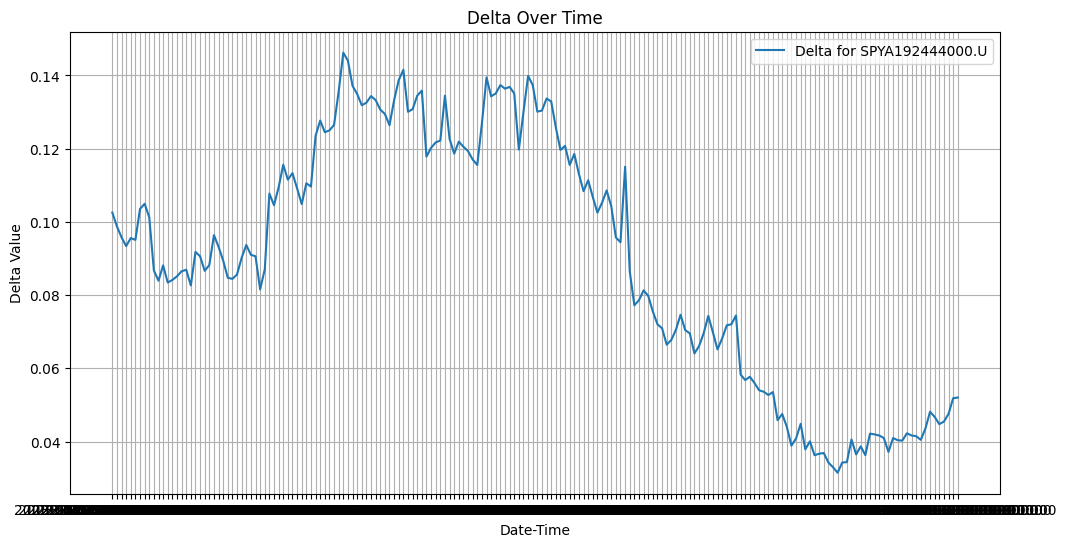

In [21]:
import matplotlib.pyplot as plt

option_ric_to_plot = 'SPYA192444000.U'

plt.figure(figsize=(12, 6))
plt.plot(delta_ts.index, delta_ts[option_ric_to_plot], label=f'Delta for {option_ric_to_plot}')
plt.title('Delta Over Time')
plt.xlabel('Date-Time')
plt.ylabel('Delta Value')
plt.legend()
plt.grid(True)
plt.show()